In [1]:
import torch
import torch.nn as nn
import gym
import time
import numpy as np
import matplotlib.pyplot as plt

### $\varepsilon$-Greedy Policy:
$$
\begin{array}{l}
\pi(a|s) =
\left\{
\begin{array}{ll}
1 - \varepsilon + \varepsilon / m,& \text{ если } a \in \mathrm{argmax}_{a' \in \mathcal{A}}\, Q(s,a'),\\
\varepsilon / m,& \text{ иначе }
\end{array}
\right.
\end{array}
$$

In [3]:
def get_epsilon_greedy_action(q_values, epsilon, action_n):
    prob = np.ones(action_n) * epsilon / action_n
    argmax_action = np.argmax(q_values)
    prob[argmax_action] += 1 - epsilon
    action = np.random.choice(np.arange(action_n), p=prob)
    return action

### Monte-Carlo Algorithm

Пусть $Q(s,a) = 0$, $N(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k \in \overline{1,K}$ делаем:

1. Согласно $\pi = \varepsilon\text{-greedy}(Q)$ получаем траекторию $\tau = (S_0,A_0,\ldots,S_T)$ и награды $(R_0,\ldots,R_{T-1})$. По ним определяем $(G_0,\ldots,G_{T-1}):$
$$
G_t = \sum\limits_{k=t}^{T-1} \gamma^{k-t} R_t,\quad G_{T-1} = R_{T-1},\quad G_{T-2} = R_{T-2} + \gamma R_{T-1},\quad G_i = R_i + \gamma G_{i+1},\quad G_{T} = Q(S_T,\pi_{greedy}(S_T)).
$$

2. Для каждого $t \in \overline{0,T-1}$ обновляем $Q$ и $N$:

$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \frac{1}{N(S_t,A_t) + 1}\big(G_t - Q(S_t,A_t)\big),
$$

$$
N(S_t,A_t) \leftarrow N(S_t,A_t) + 1
$$
Уменьшаем $\varepsilon$


In [123]:
def MonteCarlo(env, state_n, action_n, episode_n, epsilon_fun, trajectory_len=500, gamma=0.99):
    q_values = np.zeros((state_n, action_n))
    counters = np.zeros((state_n, action_n))

    total_rewards = []
    for episode in range(1, episode_n):
        last_reward = 0
        if len(total_rewards) > 0:
            last_reward = total_rewards[-1]

        epsilon = epsilon_fun(episode, episode_n, last_reward=last_reward, total_rewards=total_rewards)

        trajectory = {'states': [], 'actions': [], 'rewards': []}

        state = env.reset()
        for t in range(trajectory_len):
            action = get_epsilon_greedy_action(q_values[state], epsilon, action_n)
            next_state, reward, done, _ = env.step(action)

            trajectory['states'].append(state)
            trajectory['actions'].append(action)
            trajectory['rewards'].append(reward)

            state = next_state

            if done:
                break

        total_rewards.append(np.sum(trajectory['rewards']))

        real_trajectory_len = len(trajectory['rewards'])
        returns = np.zeros(real_trajectory_len + 1)
        for t in range(real_trajectory_len - 1, -1, -1):
            returns[t] = trajectory['rewards'][t] + gamma * returns[t + 1]

        for t in range(real_trajectory_len):
            state = trajectory['states'][t]
            action = trajectory['actions'][t]
            counters[state][action] += 1
            q_values[state][action] += (returns[t] - q_values[state][action]) / counters[state][action]

    return total_rewards

In [27]:
def moving_average(data, window):
    return np.convolve(data, np.ones(window) / window, mode='valid')

In [28]:
env = gym.make("Taxi-v3")
state_n, action_n = env.observation_space.n, env.action_space.n

In [ ]:
window = 10

def plot_results(MonteCarloDict):

    for label, MonteCarlo_total_rewards in MonteCarloDict.items():
        MonteCarlo_trajectories = np.arange(1, len(MonteCarlo_total_rewards) + 1)
        plt.plot(MonteCarlo_trajectories[:len(moving_average(MonteCarlo_total_rewards, window))], moving_average(MonteCarlo_total_rewards, window), label=label)

    plt.legend()
    plt.grid()
    plt.title('Сравнение различных алгоритмов выбора эпсилон в методе Monte-Carlo')
    plt.xlabel('№ траектории')
    plt.ylabel('Награда')
    plt.show()

In [92]:
dict = {}

In [96]:
def calculate_epsilon(episode, episode_n, last_reward):
    epsilon = 1 - episode / episode_n
    return epsilon

dict['1 - episode/episode_n'] = (MonteCarlo(env, epsilon_fun=calculate_epsilon, state_n=state_n, action_n=action_n, episode_n=2000, trajectory_len=1000, gamma=0.99))

In [97]:
def calculate_epsilon(episode, episode_n, last_reward):
    epsilon = 1 / episode
    return epsilon

dict['1/k'] = (MonteCarlo(env, state_n=state_n, action_n=action_n, epsilon_fun=calculate_epsilon, episode_n=2000, trajectory_len=1000, gamma=0.99))

In [98]:
def calculate_epsilon(episode, episode_n, last_reward):
    epsilon = max(0.1, 1 - episode / (episode_n * 1.5))
    return epsilon

dict['max(0.1, 1 - episode / (episode_n * 1.5))'] = (MonteCarlo(env, state_n=state_n, action_n=action_n, epsilon_fun=calculate_epsilon, episode_n=2000, trajectory_len=1000, gamma=0.99))

In [99]:
def calculate_epsilon(episode, episode_n, last_reward):
    epsilon = (episode_n - episode) / episode_n
    return epsilon

dict['(episode_n - episode) / episode_n'] = (MonteCarlo(env, state_n=state_n, action_n=action_n, epsilon_fun=calculate_epsilon, episode_n=2000, trajectory_len=1000, gamma=0.99))

In [100]:
def calculate_epsilon(episode, episode_n, last_reward):
    epsilon = 0.1 + (1 - 0.1) * np.e**(-0.01*episode)
    return epsilon

dict['0.1 + (1 - 0.1) * np.e**(-0.01*episode)'] = (MonteCarlo(env, state_n=state_n, action_n=action_n, epsilon_fun=calculate_epsilon, episode_n=2000, trajectory_len=1000, gamma=0.99))

In [101]:
def calculate_epsilon(episode, episode_n, last_reward):
    epsilon = min(0.1, 1 - 2*last_reward/500)
    return epsilon

dict['min(0.1, 1 - 2*last_reward/500)'] = (MonteCarlo(env, state_n=state_n, action_n=action_n, epsilon_fun=calculate_epsilon, episode_n=2000, trajectory_len=1000, gamma=0.99))

In [102]:
def calculate_epsilon(episode, episode_n, last_reward):
    epsilon_decay = 1 - episode / episode_n  # уменьшение с каждым эпизодом
    epsilon_reward_based = 1 - 2 * last_reward / 500
    epsilon = min(0.1, max(epsilon_decay, epsilon_reward_based))
    return epsilon

dict['min(0.1, 1 - max(1 - episode / episode_n, 1 - 2 * last_reward / 500)'] = (MonteCarlo(env, state_n=state_n, action_n=action_n, epsilon_fun=calculate_epsilon, episode_n=2000, trajectory_len=1000, gamma=0.99))

In [124]:
def calculate_epsilon(episode, episode_n, last_reward, total_rewards):
    epsilon = min(0.1, 1 - 2*np.mean(total_rewards[:-10])/500)
    return epsilon

dict['min(0.1, 1 - 2*np.mean(total_rewards[:-10])/500)'] = (MonteCarlo(env, state_n=state_n, action_n=action_n, epsilon_fun=calculate_epsilon, episode_n=2000, trajectory_len=1000, gamma=0.99))

c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [126]:
def calculate_epsilon(episode, episode_n, last_reward, total_rewards):
    epsilon = min(0.1, 1 - 2*np.mean(total_rewards[:-100])/500)
    return epsilon

dict['min(0.1, 1 - 2*np.mean(total_rewards[:-100])/500)'] = (MonteCarlo(env, state_n=state_n, action_n=action_n, epsilon_fun=calculate_epsilon, episode_n=2000, trajectory_len=1000, gamma=0.99))

c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [139]:
def calculate_epsilon(episode, episode_n, last_reward, total_rewards):
    epsilon = min(0.0001, 1 - np.mean(total_rewards[:-100])/500)
    return epsilon

dict['min(0.0001, np.mean(total_rewards[:-100])/500)'] = (MonteCarlo(env, state_n=state_n, action_n=action_n, epsilon_fun=calculate_epsilon, episode_n=2000, trajectory_len=1000, gamma=0.99))

c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [145]:
def calculate_epsilon(episode, episode_n, last_reward, total_rewards):
    epsilon_max = 1.0
    epsilon_min = 0.1
    decay_rate = 0.99
    epsilon = epsilon_max * (decay_rate ** episode)
    
    avg_reward = np.mean(total_rewards)

    # Если награда сильно повысилась, уменьшаем epsilon
    if np.mean(total_rewards[:-10]) > avg_reward:
        epsilon = max(epsilon_min, epsilon * 0.9)  # уменьшение epsilon
    # Если награда низкая, увеличиваем epsilon
    elif np.mean(total_rewards[:-10]) < avg_reward:
        epsilon = min(epsilon_max, epsilon * 1.1)  # увеличение epsilon
    
    return epsilon

dict['base_on_avg2'] = (MonteCarlo(env, state_n=state_n, action_n=action_n, epsilon_fun=calculate_epsilon, episode_n=2000, trajectory_len=1000, gamma=0.99))

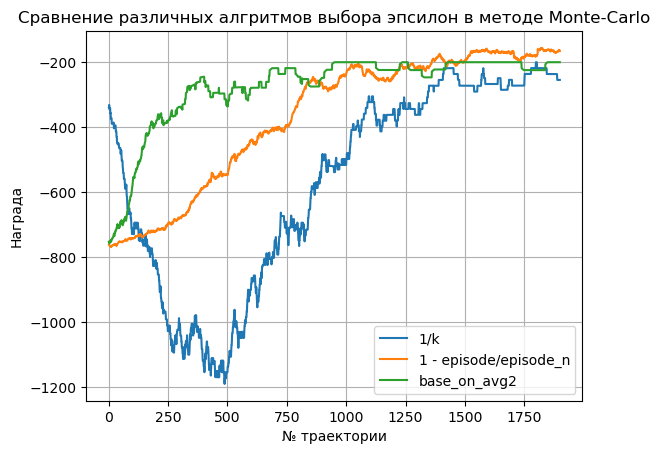

In [146]:
window = 100
keys = ["1/k", "1 - episode/episode_n", 'base_on_avg2']
filtered_data = {k: dict[k] for k in keys}
plot_results(filtered_data)

In [115]:
dict.keys()

dict_keys(['1 - episode/episode_n', '1/k', 'max(0.1, 1 - episode / (episode_n * 1.5))', '(episode_n - episode) / episode_n', '0.1 + (1 - 0.1) * np.e**(-0.01*episode)', 'min(0.1, 1 - 2*last_reward/500)', 'min(0.1, 1 - max(1 - episode / episode_n, 1 - 2 * last_reward / 500)'])